#Taller 2: Árboles de decisión

En este taller analizaremos aspectos de árboles de decisión para varios conjuntos de datos. El primero es el [Play tennis dataset](https://www.kaggle.com/datasets/fredericobreno/play-tennis). El segundo es el [Iris dataset](https://archive.ics.uci.edu/ml/datasets/iris). El tercero es el [Pima Indians Diabetes Database](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database). El cuarto es [Hitters](https://www.kaggle.com/datasets/floser/hitters).

El taller consiste en realizar todas las tareas señaladas con #TO_DO.
Se puede realizar de forma individual o en parejas.

Entregar el cuaderno ejecutado y guardado en formato .ipynb y en formato .html Cargarlo a más tardar el miércoles 22 de febrero en la actividad creada en aulas.

In [1]:
#Importar librerías
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn      import metrics
import matplotlib.pyplot as plt

import pprint
import numpy as np
import math

## Calculando el mejor atributo para el Tennis Dataset

En primer lugar, cargar y leer el conjunto de datos Play Tennis, e imprimir todas sus filas (son pocas).

In [2]:
df = pd.read_csv('play_tennis.csv').dropna()
df = df.drop('day', axis=1)
df.head(14)

,outlook,temp,humidity,wind,play
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes
5,Rain,Cool,Normal,Strong,No
6,Overcast,Cool,Normal,Strong,Yes
7,Sunny,Mild,High,Weak,No
8,Sunny,Cool,Normal,Weak,Yes
9,Rain,Mild,Normal,Weak,Yes


In [3]:
def turn_into_dict(all_cases_and_probs):

    converted = dict([(variable, {}) for variable, _ in all_cases_and_probs.keys()])
    
    for variable, outcome in all_cases_and_probs.keys():
        converted[variable][outcome] = all_cases_and_probs[(variable, outcome)]

    return converted



def get_probabilities(data: pd.DataFrame, output_event = 'play'):

    nsamples = len(data)

    #gets the variable names (column names)
    variables = list(data.drop(output_event, axis=1).columns)
    
    #gets the different kind of outputs of the output event
    outcomes = list(data[output_event].unique())

    #dictiorary with the probabilities of all the cases
    all_cases_and_probs = {}
    
    ocurrences = {} 

    for variable in variables:
        #count the number of times a different value for the variable has been got
        tot_of_ocurrences = data.groupby([variable]).size().to_dict()

        #gets the number of ocurrences of the combinations of variables
        #and outcomes
        cases = data.groupby([variable, output_event]).size().to_dict()


        #calculates the probability
        for var_type, outcome in cases.keys():
            cases[(var_type, outcome)] /= tot_of_ocurrences[var_type]
            ocurrences[var_type] = tot_of_ocurrences[var_type]/nsamples
            

        #merges and updates dictionary
        all_cases_and_probs |= cases

    all_cases_and_probs = turn_into_dict(all_cases_and_probs)

    return all_cases_and_probs, ocurrences


def get_gains(data: pd.DataFrame, output_event = 'play'):

    output_outcomes =  data.groupby([output_event]).size().to_dict()
    outcomes_num = data.groupby([output_event]).size().sum()

    for outcome in output_outcomes:
        output_outcomes[outcome] /= outcomes_num       

    #probabilities of the outcomes
    pk_output = np.array(list(output_outcomes.values()))

    #entropy of the output event we are looking forward to predict
    out_entropy = -np.dot(pk_output, np.log2(pk_output))

    #-------------------------------------------------------

    probs, ocurrence_rates = get_probabilities(df)
    gains = {}

    for event in probs.keys():
        gains[event] = out_entropy

        for outcome in probs[event].keys():
            p = probs[event][outcome]
            ocurrence_rate = ocurrence_rates[event]
            gains[event] -= p*np.log2(p)*ocurrence_rate

    return gains




In [4]:
probability_of_cases, ocurrence_rate = get_probabilities(df)
pp = pprint.PrettyPrinter(indent=4)

print("probability of each case:")
pp.pprint(probability_of_cases)
print()

print("ocurrence rate of events:")
pp.pprint(ocurrence_rate)


probability of each case:
{   'Cool': {'No': 0.25, 'Yes': 0.75},
    'High': {'No': 0.5714285714285714, 'Yes': 0.42857142857142855},
    'Hot': {'No': 0.5, 'Yes': 0.5},
    'Mild': {'No': 0.3333333333333333, 'Yes': 0.6666666666666666},
    'Normal': {'No': 0.14285714285714285, 'Yes': 0.8571428571428571},
    'Overcast': {'Yes': 1.0},
    'Rain': {'No': 0.4, 'Yes': 0.6},
    'Strong': {'No': 0.5, 'Yes': 0.5},
    'Sunny': {'No': 0.6, 'Yes': 0.4},
    'Weak': {'No': 0.25, 'Yes': 0.75}}

ocurrence rate of events:
{   'Cool': 0.2857142857142857,
    'High': 0.5,
    'Hot': 0.2857142857142857,
    'Mild': 0.42857142857142855,
    'Normal': 0.5,
    'Overcast': 0.2857142857142857,
    'Rain': 0.35714285714285715,
    'Strong': 0.42857142857142855,
    'Sunny': 0.35714285714285715,
    'Weak': 0.5714285714285714}


In [5]:
get_gains(df)

{'Overcast': 0.9402859586706309,
 'Rain': 1.2870540281187268,
 'Sunny': 1.2870540281187268,
 'Cool': 1.1720797085160974,
 'Hot': 1.2260002443849165,
 'Mild': 1.333841316122555,
 'High': 1.4329000266877565,
 'Normal': 1.2361223479617947,
 'Strong': 1.3688573872420593,
 'Weak': 1.403873458361564}

**TO_DO 1**
Clacular la ganancia de información  para cada variable: 
$Gain(S,A)=Ent(S)-\sum_{v\in values(A)}\frac{|S_v|}{|S|}Ent(S_v)$

¿Cuál sería el mejor atributo para comenzar el árbol?
Observación: Puede hacer sus cálculos a mano y adjuntar una imagen de los mismos, o programar. 


In [6]:
entropy_outlook=(5/14)*((-2/5)*math.log2(2/5)+(-3/5)*math.log2(3/5))+(4/14)*(0)+(5/14)*((-3/5)*math.log2(3/5)+(-2/5)*math.log2(2/5))
entropy_temp=(4/14)*((-2/4)*math.log2(2/4)+(-2/4)*math.log2(2/4))+(6/14)*((-4/6)*math.log2(4/6)+(-2/6)*math.log2(2/6))+(4/14)*((-3/4)*math.log2(3/4)+(-1/4)*math.log2(1/4))
entropy_humidity=(7/14)*((-3/7)*math.log2(3/7)+(-4/7)*math.log2(4/7))+(7/14)*((-6/7)*math.log2(6/7)+(-1/7)*math.log2(1/7))
entropy_wind=(8/14)*((-6/8)*math.log2(6/8)+(-2/8)*math.log2(2/8))+(6/14)*((-3/6)*math.log2(3/6)*2)
entropy_s=(-9/14)*math.log2(9/14)-(5/14)*math.log2(5/14)

dict = {'outlook' : (entropy_s-entropy_outlook), 'temp': (entropy_s-entropy_temp), 'humidity': (entropy_s-entropy_humidity), 'wind': (entropy_s-entropy_wind)}

print(dict)

{'outlook': 0.2467498197744391, 'temp': 0.029222565658954647, 'humidity': 0.15183550136234136, 'wind': 0.04812703040826927}


## Árbol de decisión para clasificación del Iris Dataset

Primero definimos el clasificador y lo entrenamos con el conjunto de datos de entrenamiento.

In [7]:
#TO_DO 2 Importar el Iris Dataset usando load_iris de sklearn (ya se importó load_iris). Darle el nombre 'iris'.
# Guardar en X,y las variables de entrada y salida respectivamente, en tipo DataFrame.
# Usar iris.data, iris.target.
(X, y) = load_iris(return_X_y=True)

In [8]:
#TO_DO 3 Separar en Train y Test set con una proporción de 70%-30%.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [9]:
#TO_DO 4 Definir un clasificador de árbol de decisión con DecisionTreeClassifier de SKLearn. 
#Usar los parámetros random_state=0 y criterion='entropy'
#Entrenarlo

clf = DecisionTreeClassifier(random_state=0, criterion='entropy')
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

Medimos la precisión: la proporción entre predicciones correctas y el total de predicciones:

In [10]:
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9777777777777777


**Plot**
Graficamos el árbol obtenido mediante el uso de plot_tree.
To_do 5
¿Qué información identifica en el árbol?

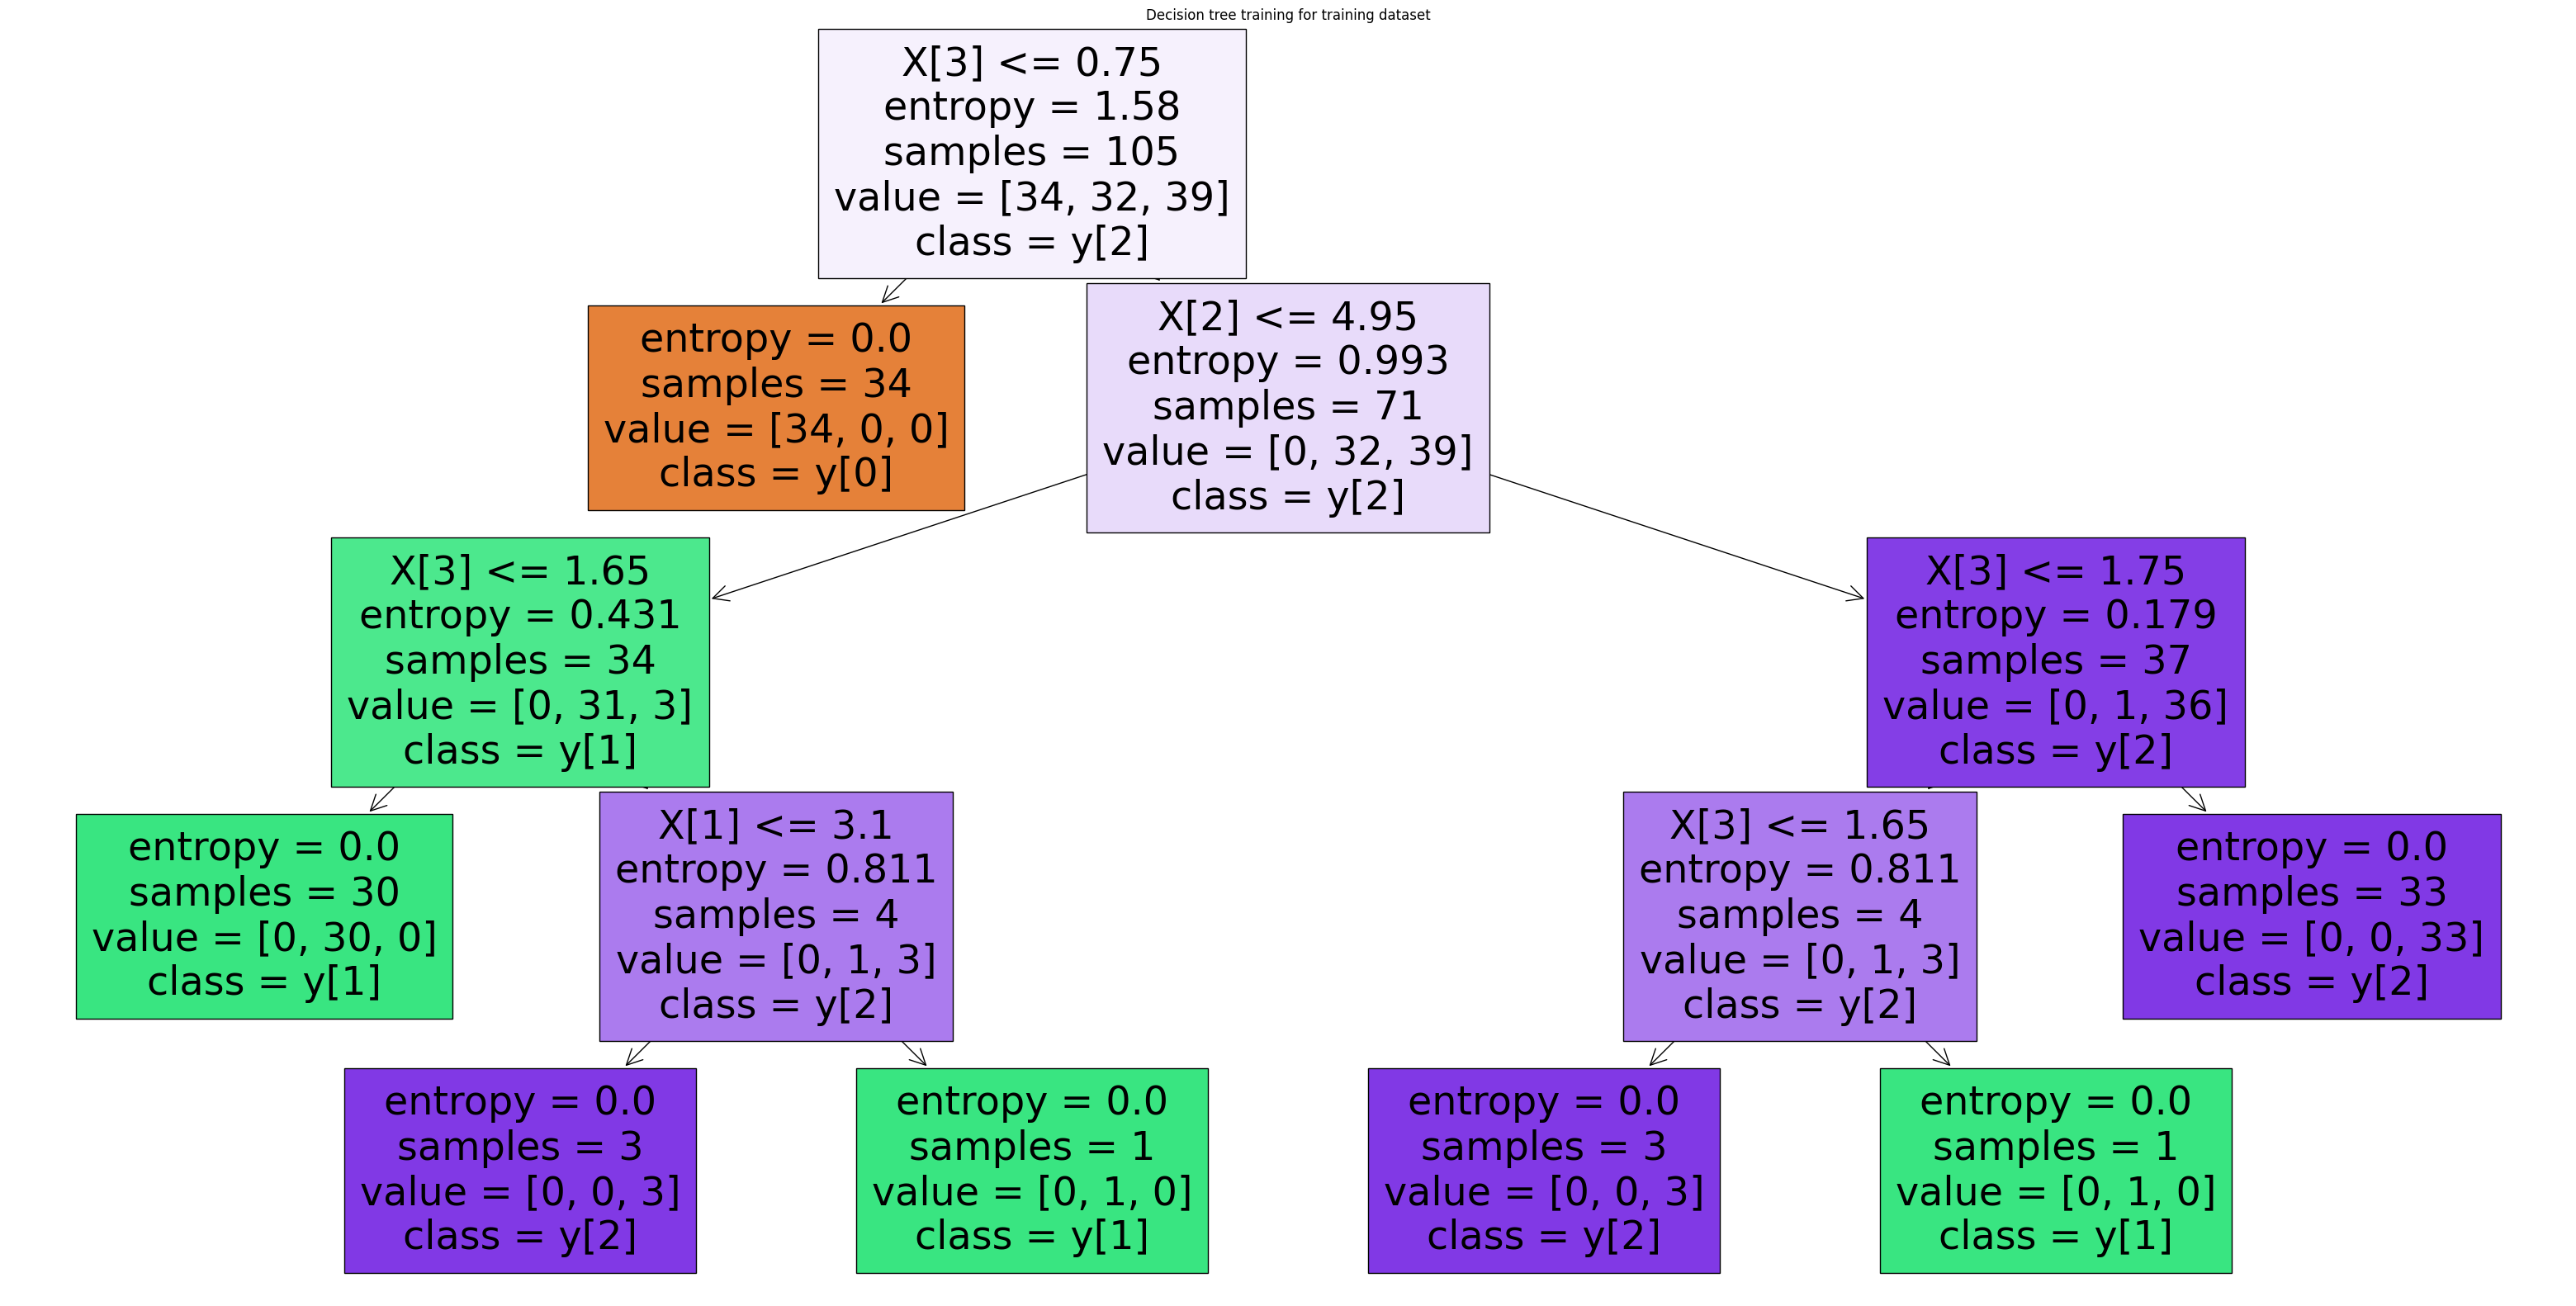

In [11]:
plt.figure(figsize=(40,20))
plot_tree(clf, filled=True, class_names=True)
plt.title("Decision tree training for training dataset")
plt.show()

Podemos notar que la variable más potente inicialmente en este caso es x[3]. Además, hay tres clases. Por último podemos ver que la entropía va disminuyendo a medida que nos acercamos a las hojas del árbol.

**TO_DO 6**: Explore algunos métodos del DecisionTreeClassifier como apply, get_depth, get_n_leaves. Calcúlelos y corrobore su resultado usando el diagrama de árbol. 

In [12]:
# Aplicar métodos apply, get_depth, get_n_leaves y entender lo que dicen del árbol.
print(f"profundidad: {clf.get_depth()}")
print(f"N. Hojas: {clf.get_n_leaves()}")
print(f"Apply: {clf.apply(X_train)}")


profundidad: 4
N. Hojas: 7
Apply: [ 4 12 12 10 12  4 12  4  4  6 10  6 12  4 12  4  1 12  4  4  4  4 12  1
  1 12  4  1  1  4  1 12  4  1  4 12  4  1 12 12 12 12  1  1 12 12  1 12
  1 12 12  1  1 10  1  1  1  4 12 12  1  1  1  4  4  1  1  4  1 12  4 12
  4  1  6  1 12  1  1 12  1 12  4  4  4 12 12  4 11  1  4 12 12  1  4  4
  7  4  1  1  1 12  4 12  1]


## Diabetes Dataset






A continuación se entrenará un árbol de decisión para el conjunto de datos sobre diabetes. 

**TO_DO 7**:
- Entrene un árbol de decisión utilizando el clasificador de SKLearn con un conjunto de entrenamiento del 80% del dataset. Utilice random_state=0 y el criterio de entropía. 

**TO_DO 8**: 
- Grafique el árbol. ¿Cuál es la precisión de este modelo?

In [13]:
## Su código aquí
data_diab = pd.read_csv('diabetes.csv')
data_diab.head(3)

X = data_diab.loc[:, data_diab.columns != "Outcome"]
y = data_diab['Outcome']

In [14]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [15]:
clf2 = DecisionTreeClassifier(random_state=0, criterion='entropy')
clf2.fit(X_train2, y_train2)

DecisionTreeClassifier(criterion='entropy', random_state=0)

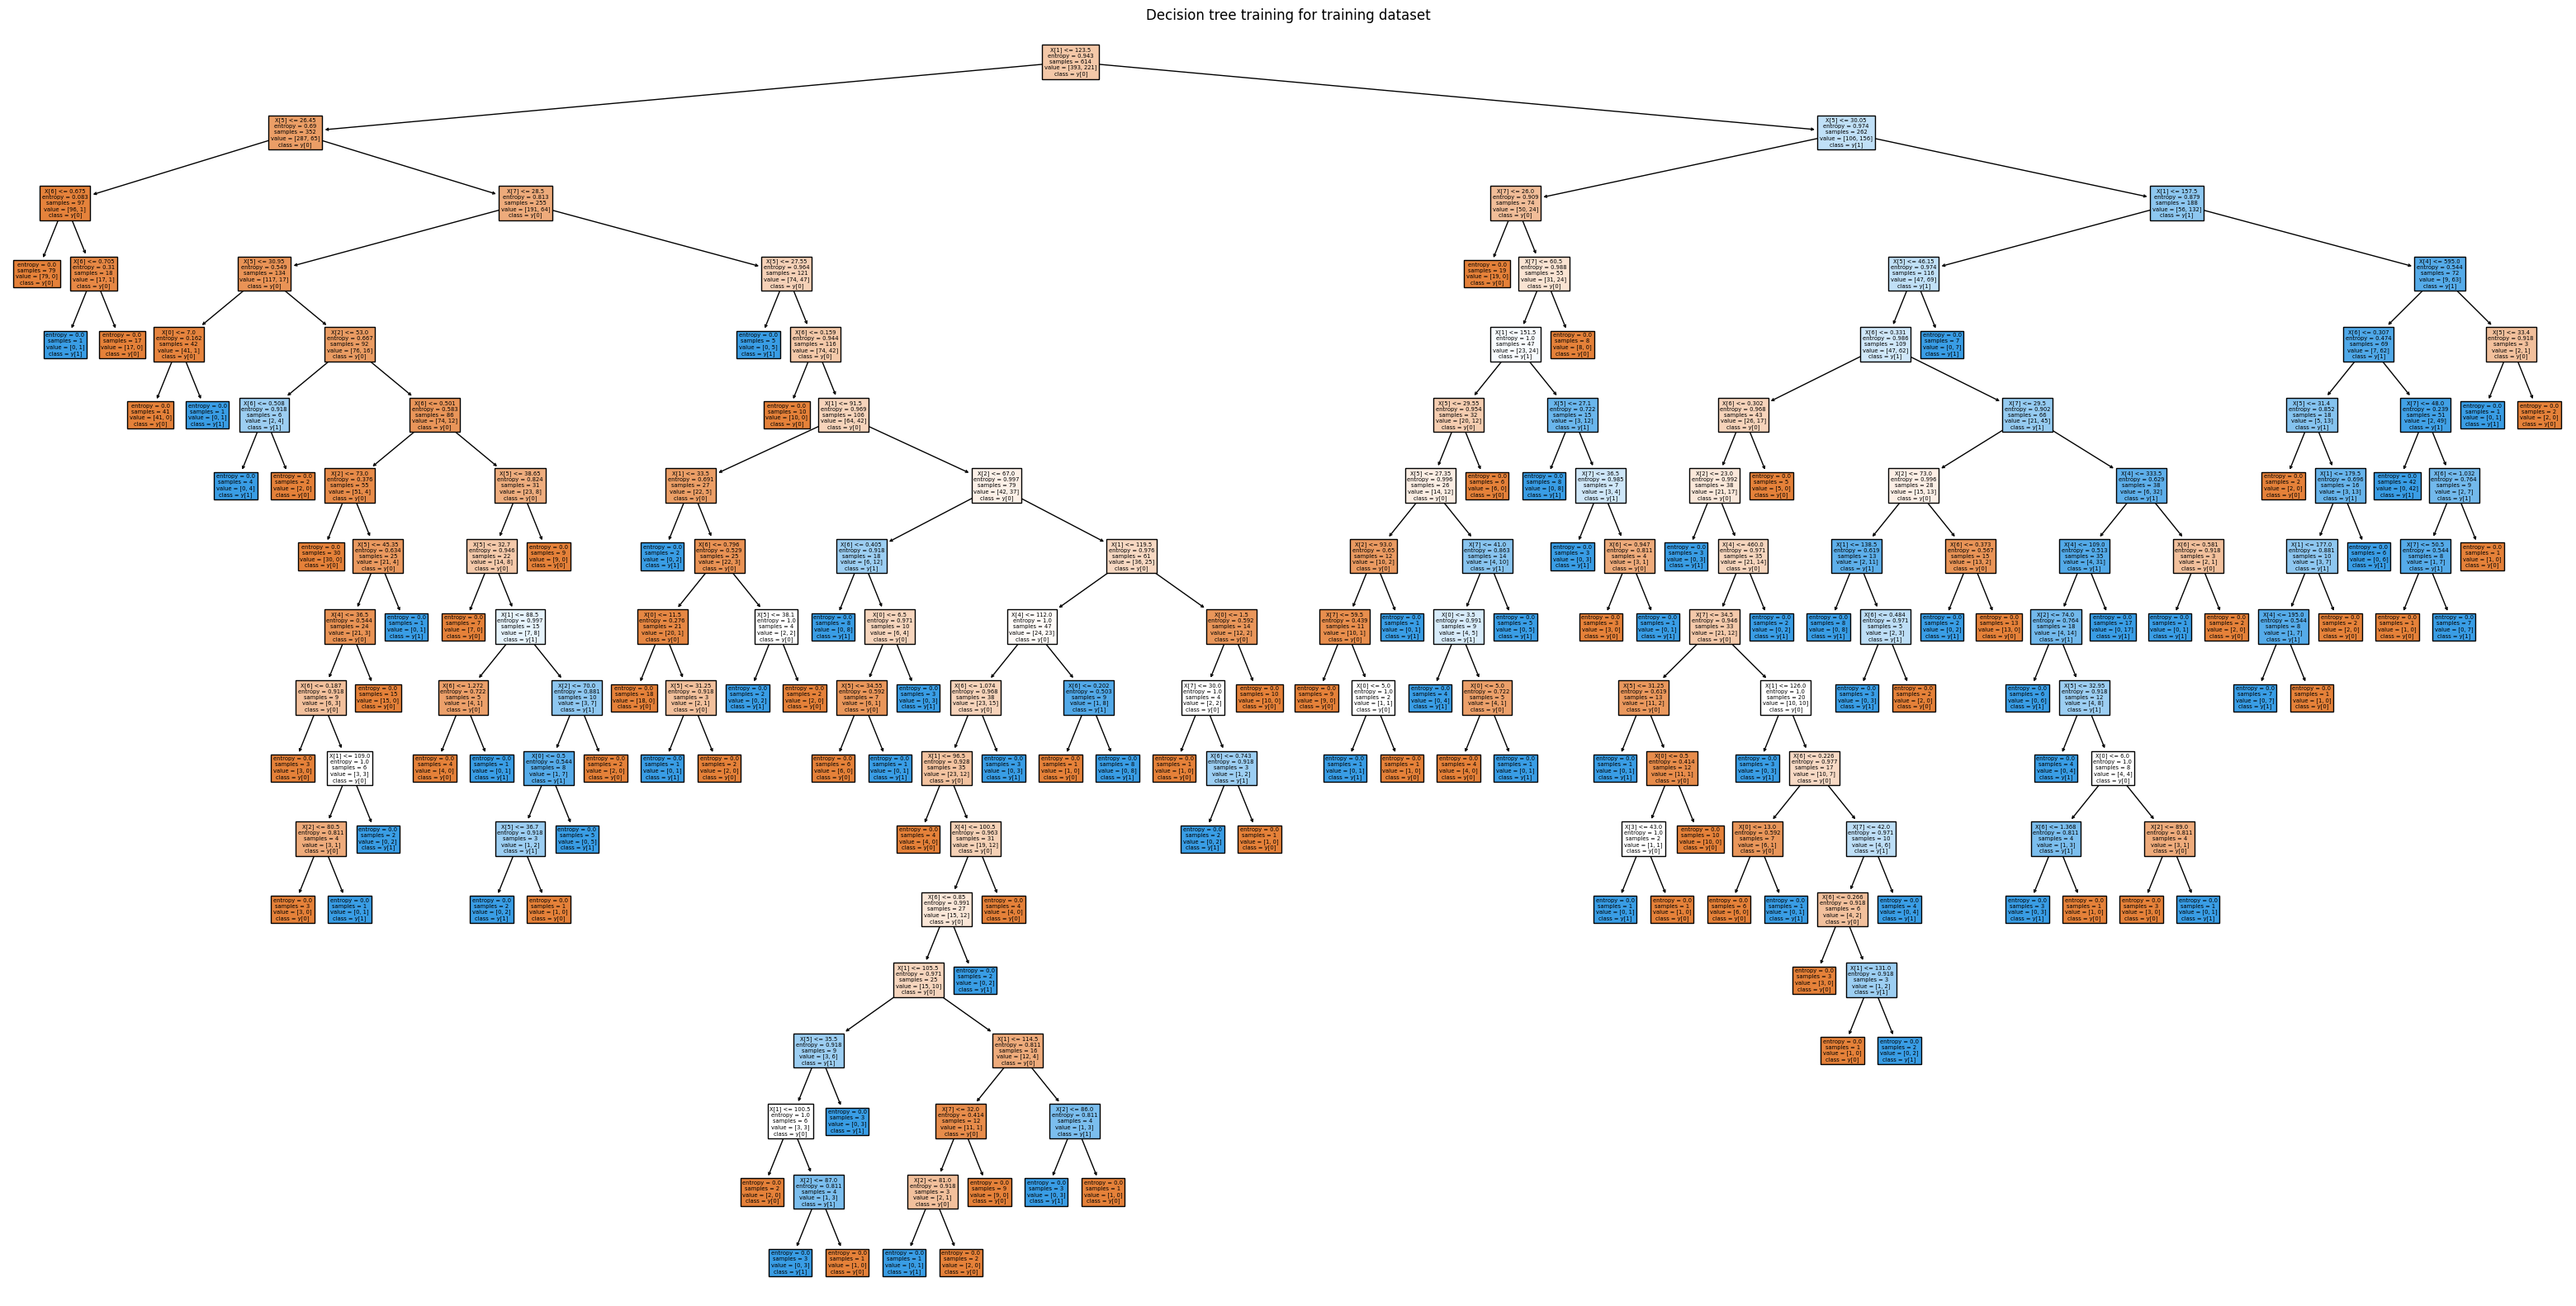

In [16]:
plt.figure(figsize=(40,20))
plot_tree(clf2, filled=True, class_names=True)
plt.title("Decision tree training for training dataset")
plt.show()

In [17]:
print(f"profundidad: {clf2.get_depth()}")
print(f"N. Hojas: {clf2.get_n_leaves()}")

profundidad: 17
N. Hojas: 108


In [18]:
y_pred2 = clf2.predict(X_test2)
print("Accuracy:",metrics.accuracy_score(y_test2, y_pred2))

Accuracy: 0.7077922077922078


## Poda del árbol

Uno de los parámetros del DecisionTreeClassifier es *ccp_alpha*, el cual es un parámetro para la poda del árbol mediante el método *Mínimal cost complexity*. El código siguiente arroja una lista de valores de alpha que resultan efectivos en la poda del árbol. 

Entre mayor es el valor de $\alpha$, más se poda el árbol. 

In [19]:
path = clf.cost_complexity_pruning_path(X_train2, y_train2)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
ccp_alphas

array([0.        , 0.00325733, 0.00325733, 0.00325733, 0.00354114,
       0.00404381, 0.00434311, 0.00448679, 0.00448679, 0.00448679,
       0.00448679, 0.00448679, 0.00448679, 0.0046164 , 0.00468704,
       0.0048303 , 0.0048303 , 0.00495964, 0.00502633, 0.00522067,
       0.0052852 , 0.0055433 , 0.00560085, 0.00575644, 0.00587889,
       0.00594704, 0.00602679, 0.00604632, 0.00604745, 0.00605368,
       0.00618329, 0.00640444, 0.0064094 , 0.00654328, 0.00655698,
       0.00674546, 0.00684674, 0.00690069, 0.00697625, 0.00702367,
       0.00737675, 0.00768763, 0.00785562, 0.00787552, 0.00812098,
       0.00818056, 0.0086791 , 0.00869433, 0.00897357, 0.00914306,
       0.00924392, 0.00994398, 0.01118351, 0.01151191, 0.0120048 ,
       0.01282652, 0.02102938, 0.02130657, 0.0278788 , 0.03683399,
       0.04500223, 0.13153424])

**TO_DO 9:** 
Usando el arreglo de valores de *ccp_alpha* arrojados en la celda anterior, crear un loop que entrene un árbol para cada parámetro de ccp_alpha e imprima su precisión. 
¿Cuál es el valor de ccp_alpha optimo?

In [20]:
## código aquí

for ccp_alpha in ccp_alphas:

    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train2, y_train2)
    y_pred2 = clf.predict(X_test2)
    accuracy = metrics.accuracy_score(y_test2, y_pred2)
    print("ccp_alpha = {:.8f}, accuracy = {:.4f}".format(ccp_alpha, accuracy))

ccp_alpha = 0.00000000, accuracy = 0.7662
ccp_alpha = 0.00325733, accuracy = 0.7987
ccp_alpha = 0.00325733, accuracy = 0.7987
ccp_alpha = 0.00325733, accuracy = 0.7987
ccp_alpha = 0.00354114, accuracy = 0.8182
ccp_alpha = 0.00404381, accuracy = 0.8052
ccp_alpha = 0.00434311, accuracy = 0.7468
ccp_alpha = 0.00448679, accuracy = 0.7468
ccp_alpha = 0.00448679, accuracy = 0.7468
ccp_alpha = 0.00448679, accuracy = 0.7468
ccp_alpha = 0.00448679, accuracy = 0.7468
ccp_alpha = 0.00448679, accuracy = 0.7468
ccp_alpha = 0.00448679, accuracy = 0.7468
ccp_alpha = 0.00461640, accuracy = 0.7597
ccp_alpha = 0.00468704, accuracy = 0.7597
ccp_alpha = 0.00483030, accuracy = 0.7597
ccp_alpha = 0.00483030, accuracy = 0.7597
ccp_alpha = 0.00495964, accuracy = 0.7662
ccp_alpha = 0.00502633, accuracy = 0.7662
ccp_alpha = 0.00522067, accuracy = 0.7662
ccp_alpha = 0.00528520, accuracy = 0.7792
ccp_alpha = 0.00554330, accuracy = 0.7792
ccp_alpha = 0.00560085, accuracy = 0.7792
ccp_alpha = 0.00575644, accuracy =

Los ccp_alphas más óptimos son: 0.00334664 y 0.00391165, con un valor de 0.8182.

**TO_DO 10:**
Entrenar un clasificador con el ccp_alpha óptimo. Graficarlo y compararlo con el árbol inicial. 

In [21]:
optimal_ccp = 0.00334664
clf3 = DecisionTreeClassifier(random_state=0, ccp_alpha=optimal_ccp)
clf3.fit(X_train2, y_train2)

DecisionTreeClassifier(ccp_alpha=0.00334664, random_state=0)

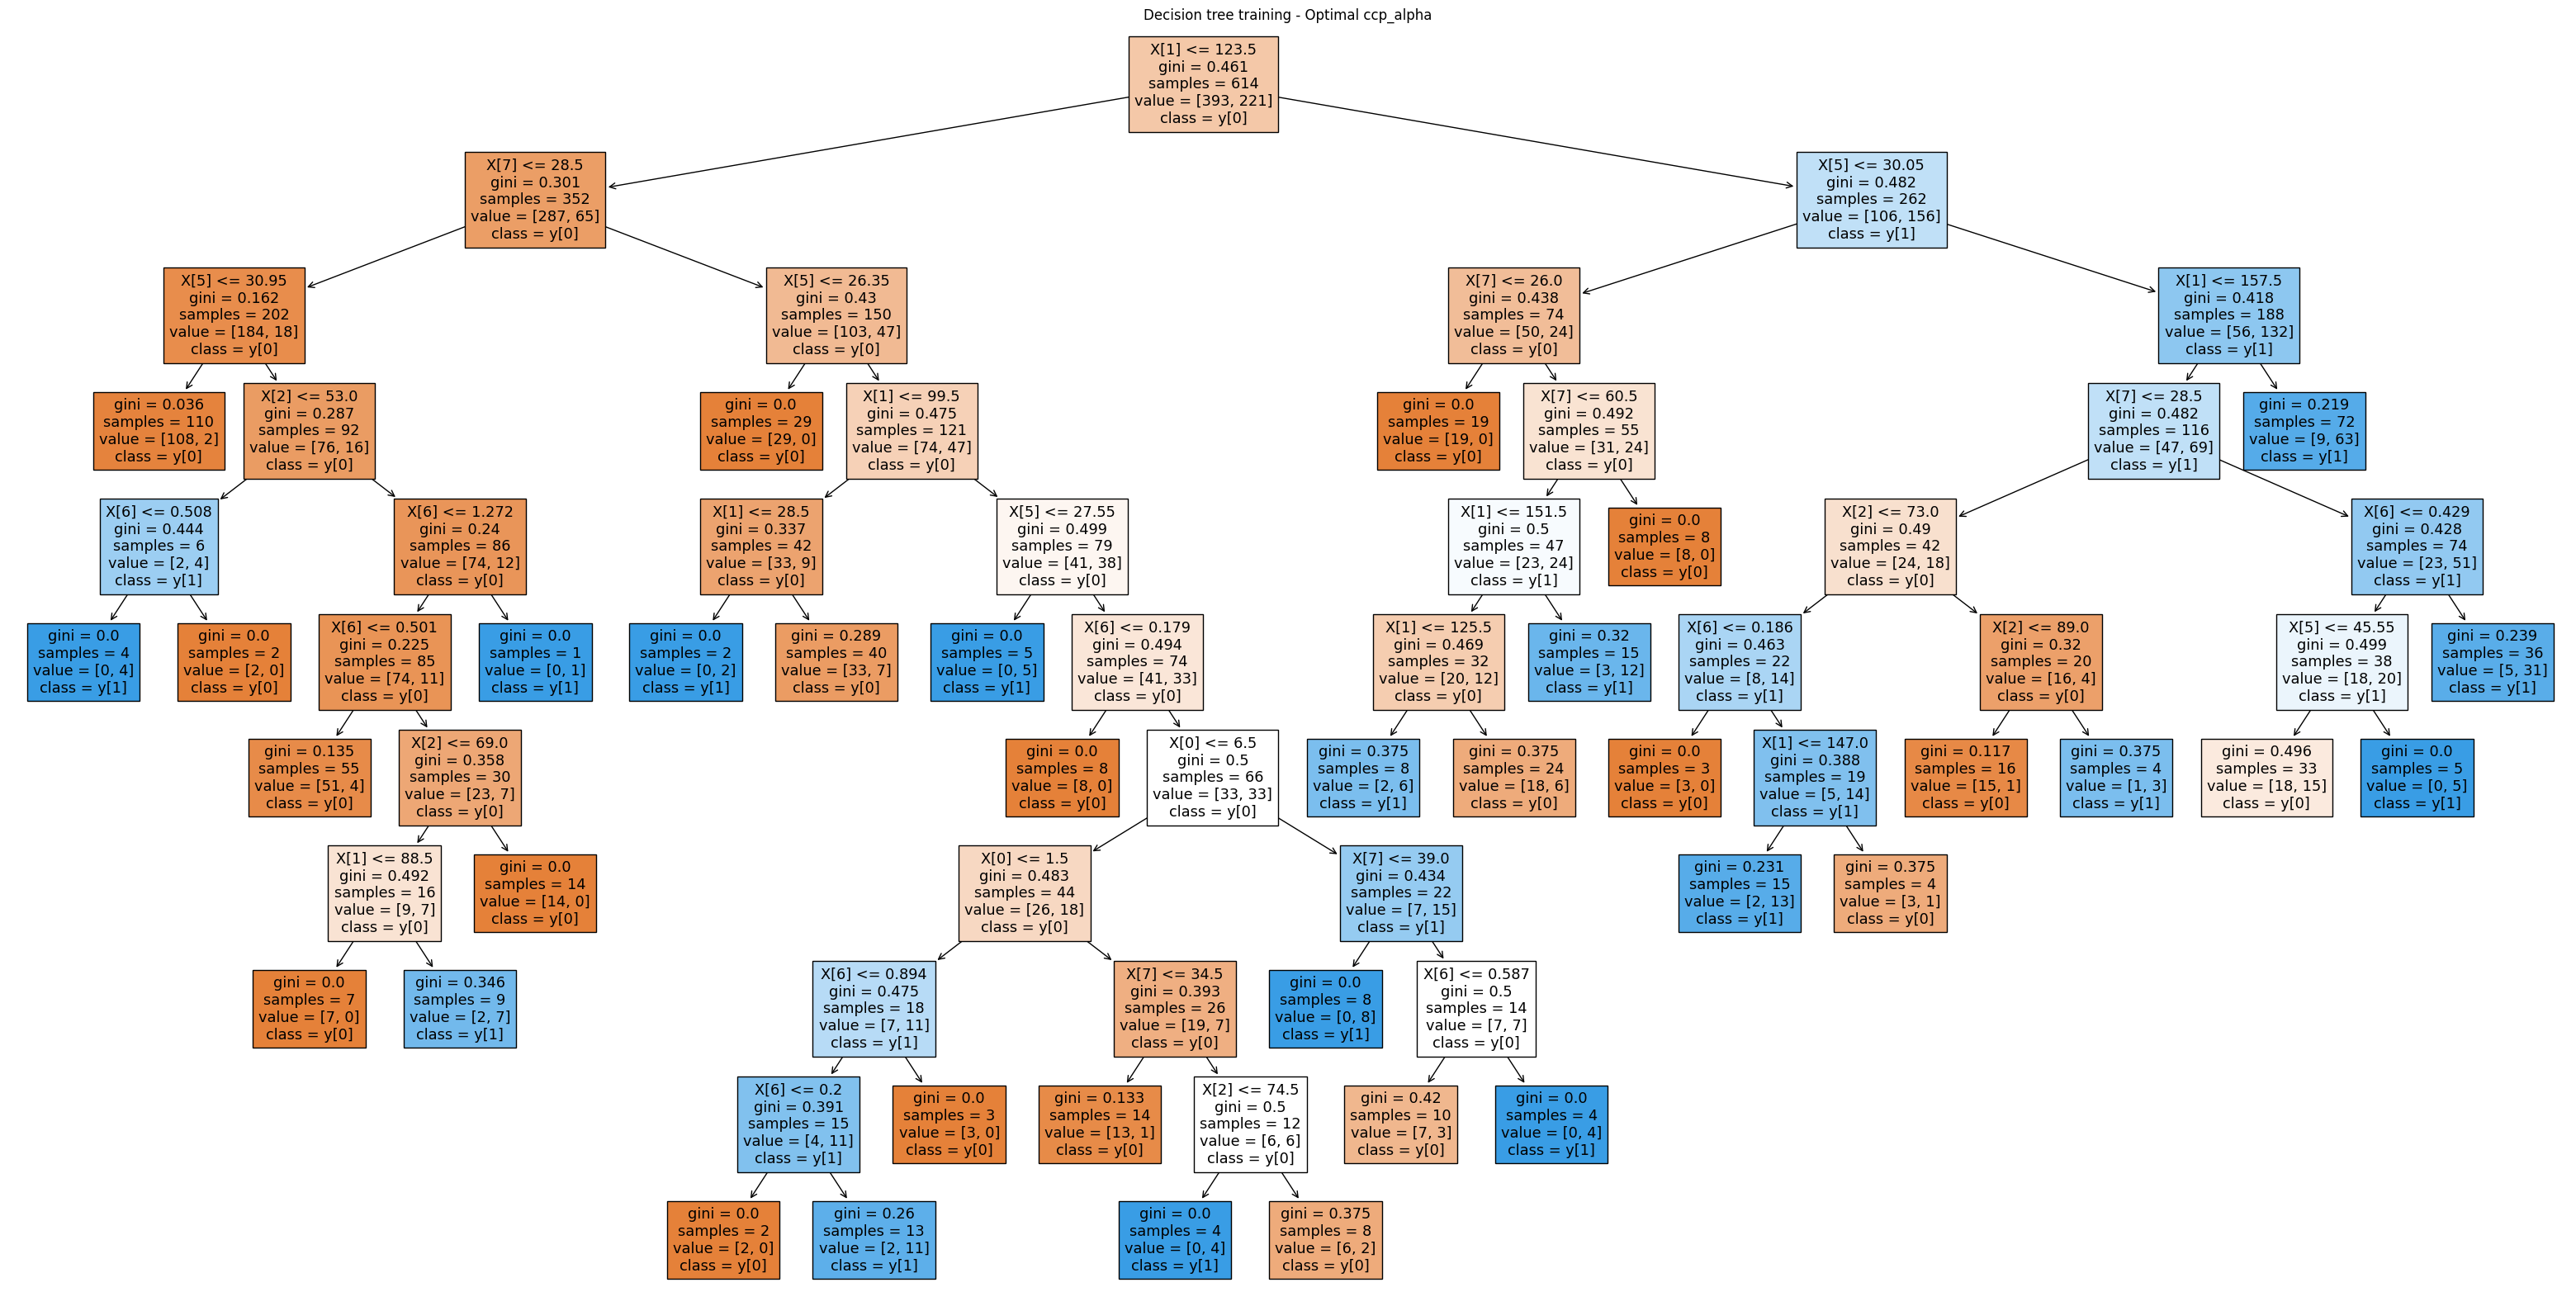

In [22]:
plt.figure(figsize=(40, 20))
plot_tree(clf3, filled=True, class_names=True)
plt.title("Decision tree training - Optimal ccp_alpha")
plt.show()

In [23]:
print(f"profundidad: {clf3.get_depth()}")
print(f"N. Hojas: {clf3.get_n_leaves()}")

profundidad: 10
N. Hojas: 36


Comparado con el árbol inicial, podemos ver que su profundidad y número de nodos es menor.

## Árbol de regresión

Para éste ejercicio usamos el dataset de Hitters, cuya variable objetivo es el salario, el cual no es una variable categórica. Para esto necesitamos un árbol de regresión. A saber, DecisionTreeRegressor. 

Primero leemos el dataset, y consideramos como entrada  X únicamente dos de sus variables: Years, Hits. Tomamos como variable objetivo el salario.

In [24]:
df3 = pd.read_csv('Hitters.csv').dropna()
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 
dtypes: float64

In [25]:
X = df3[['Years', 'Hits']] # Tomamos sólo dos de las columnas
y = df3.Salary

**TO_DO 11**
Entrenar un árbol de regresión en X,y con el parámetro max_leaf_nodes=3; usar el método score (coeficiente de determinación)para medir su desempeño, y graficarlo.


In [26]:
## código aquí
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size = 0.2, random_state = 0)

regressor = DecisionTreeRegressor(max_leaf_nodes=3)
regressor.fit(X_train3, y_train3)

score = regressor.score(X_train3, y_train3)
print("R²:", score) 

R²: 0.47162874190019377


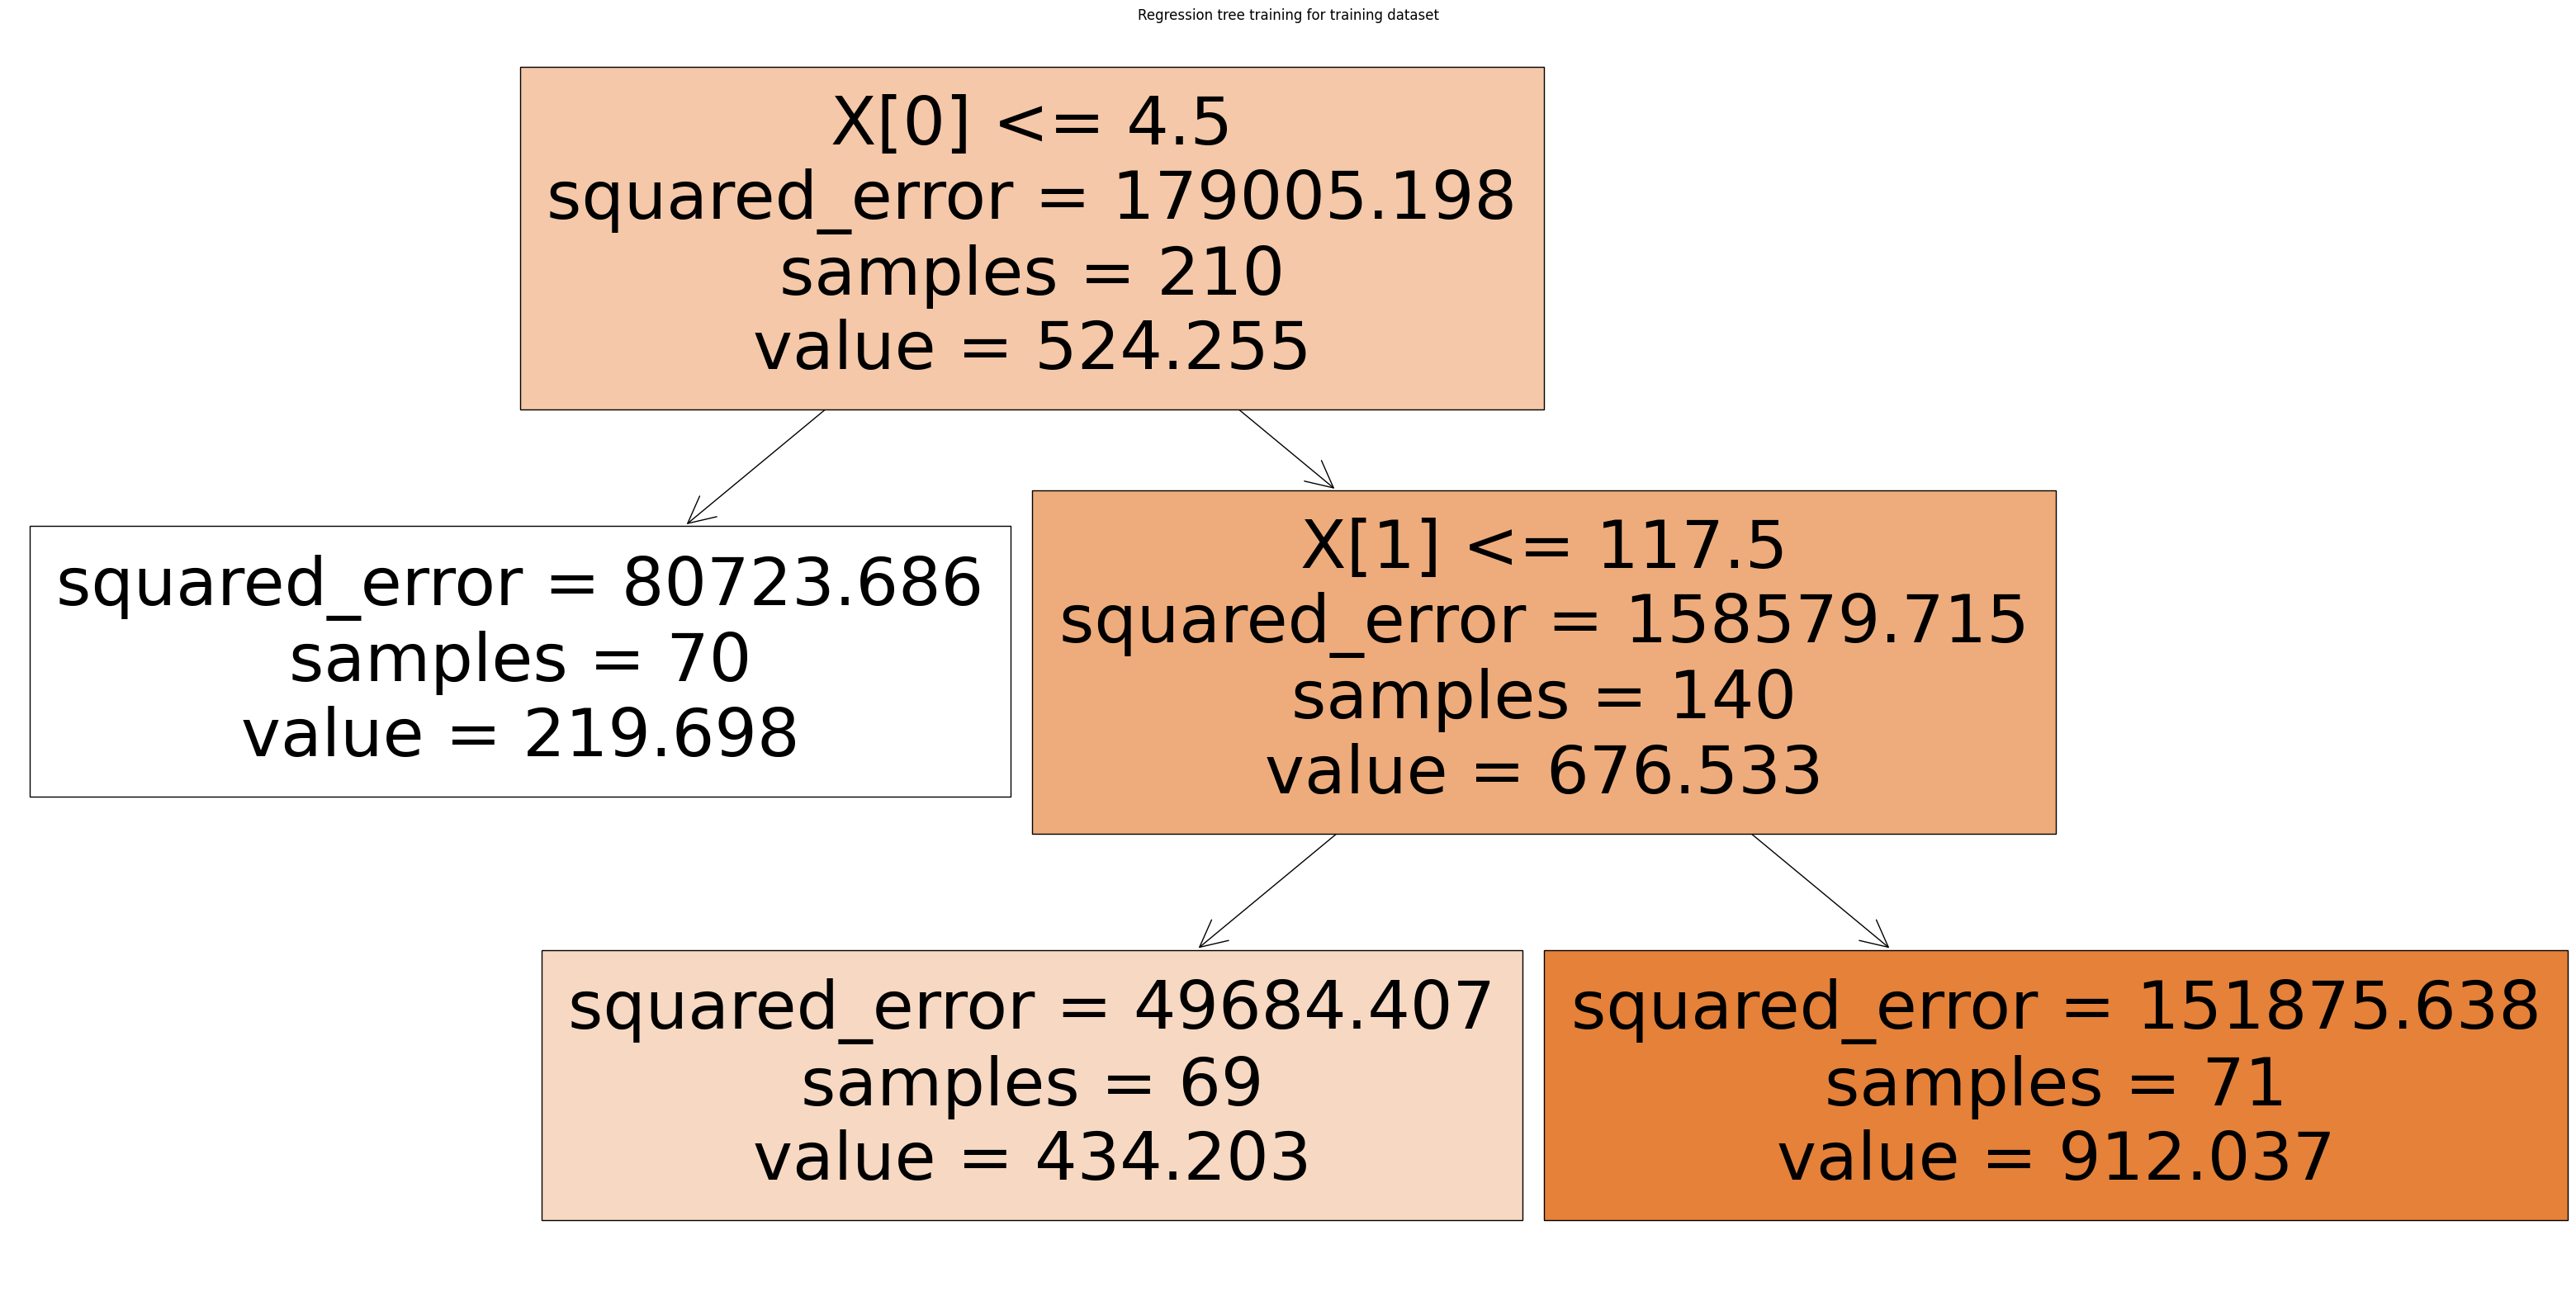

In [27]:
## Graficar el árbol

plt.figure(figsize=(40,20))
plot_tree(regressor, filled=True, class_names=True)
plt.title("Regression tree training for training dataset")
plt.show()

**TO_DO 12:**
¿En cuántas regiones $R_i$ separó el espacio de las dos variables de entrada el árbol anterior? Descríbalas.

Podemos notar que tendremos 3 regiones (la cantidad de hojas del árbol). La cuáles serán:

- La región 1 estaría dada cuando $x[0] \leq 4.5$.
- La región 2 cuando $x[0] \geq4.5$ y $x[0] \leq 117.5$.
- La región 3 cuando $x[0] \geq4.5$ y $x[0] \geq 117.5$.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=850b3a4c-20d2-4125-9147-49537f39c92e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>